In [21]:
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import timedelta
import seaborn as sns
from timeit import default_timer
import cartopy.crs as ccrs
# import seaborn as sns
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 14
})


In [2]:
dummy = xr.open_mfdataset("/pscratch/sd/a/amahesh/hens/demo_bred_1step/ensemble_out_0000*_2020-06-18-00-00-00.nc",
                     group='global', concat_dim='ensemble', combine='nested')

In [3]:
ifs_ds = xr.open_mfdataset("/pscratch/sd/a/amahesh/tigge/d2m_t2m_summer23/sfc/sfcvars__ens_2023_*.grib",
                       concat_dim='time', combine='nested')



Can't read index file '/pscratch/sd/a/amahesh/tigge/d2m_t2m_summer23/sfc/sfcvars__ens_2023_07_04_raw.grib.923a8.idx'
Traceback (most recent call last):
  File "/global/common/software/m4416/fcn_mip-env/lib/python3.10/site-packages/cfgrib/messages.py", line 547, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/global/common/software/m4416/fcn_mip-env/lib/python3.10/site-packages/cfgrib/messages.py", line 429, in from_indexpath
    index = pickle.load(file)
EOFError: Ran out of input
Can't read index file '/pscratch/sd/a/amahesh/tigge/d2m_t2m_summer23/sfc/sfcvars__ens_2023_07_13_raw.grib.923a8.idx'
Traceback (most recent call last):
  File "/global/common/software/m4416/fcn_mip-env/lib/python3.10/site-packages/cfgrib/messages.py", line 547, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/global/common/software/m4416/fcn_mip-env/lib/python3.10/site-packages/cfgrib/messages.py", line 429, in from_indexpath
    index = pickl

In [4]:
def load_hensmax(curr_date, curr_date_idx):
    stats_ds = xr.open_mfdataset(f"/pscratch/sd/a/amahesh/hens_h5/stats/t2m_{curr_date:%Y%m%d}_reduced-lead-04-07-10.h5")
    stats_ds = stats_ds.rename({"phony_dim_2" : 'lat',
                     "phony_dim_3" : 'lon',
                     'phony_dim_1' : 'lead_time'})
    stats_ds['lat'] = dummy['lat']
    stats_ds['lon'] = dummy['lon']
    # Select 10 day lead time
    return stats_ds['t2m_max'].isel(phony_dim_0=curr_date_idx, lead_time=[8,9,10,11]).values

def load_ifsmax(ifs_ds, curr_date):
    ifs = ifs_ds.sel(time=f"{curr_date:%Y-%m-%d}").rename({'latitude' : 'lat', 
                                                      'longitude' : 'lon'})
    ifs = ifs.sel(step=slice(np.timedelta64(10, 'D'),np.timedelta64(258, 'h')))
    ifs_max = ifs['t2m'].max('number').rename({
                                               'step' : 'lead_time'})
    return ifs_max.values
    
def load_analysis(curr_date):
    valid_date = curr_date + timedelta(days=10)
    print(valid_date)
    analysis = xr.open_dataset(f"/pscratch/sd/a/amahesh/tigge/analysis/ifs_analysis-2023-{valid_date.month:02d}.grib")
    true_t2m = analysis['t2m'].sel(time=f"{valid_date:%Y-%m-%d}").rename({'latitude' : 'lat', 
                                                  'longitude' : 'lon'})
    return true_t2m.values

def load_era5(curr_date):
    valid_date = curr_date + timedelta(days=10)
    print(valid_date)
    true = xr.open_dataset("/pscratch/sd/p/pharring/74var-6hourly/staging/2023.h5", mode='r')
    true = true.rename({'phony_dim_0' : 'time',
                        'phony_dim_2' : 'lat', 
                 'phony_dim_3' : 'lon',
                 'phony_dim_1' : 'channel'})
    true['lat'] = dummy['lat']
    true['lon'] = dummy['lon']
    true['channel'] = ["u10m", "v10m", "u100m", "v100m", "t2m", "sp", "msl", "tcwv", "2d", "u50", "u100", "u150", "u200", "u250", "u300", "u400", "u500", "u600", "u700", "u850", "u925", "u1000", "v50", "v100", "v150", "v200", "v250", "v300", "v400", "v500", "v600", "v700", "v850", "v925", "v1000", "z50", "z100", "z150", "z200", "z250", "z300", "z400", "z500", "z600", "z700", "z850", "z925", "z1000", "t50", "t100", "t150", "t200", "t250", "t300", "t400", "t500", "t600", "t700", "t850", "t925", "t1000", "q50", "q100", "q150", "q200", "q250", "q300", "q400", "q500", "q600", "q700", "q850", "q925", "q1000"]
    true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')

    true = true.sel(time=f"{valid_date:%Y-%m-%d}")
    true_t2m = true['fields'].sel(channel='t2m')
    return true_t2m.values

def load_mu_sigma(curr_date):
    valid_date = curr_date + timedelta(days=10)
    print(valid_date)
    mu, sigma = [],[]
    for hour in [0,6,12,18]:
        mu.append(xr.open_zarr(f"/pscratch/sd/a/amahesh/hens/thresholds/t2m_mean_{valid_date.month:02d}_{hour:02d}/").rename({'VAR_2T' : 't2m',
                        'latitude' : 'lat', 
                        'longitude' : 'lon'}))
        sigma.append(xr.open_zarr(f"/pscratch/sd/a/amahesh/hens/thresholds/t2m_std_{valid_date.month:02d}_{hour:02d}/").rename({'VAR_2T' : 't2m',
                        'latitude' : 'lat', 
                        'longitude' : 'lon'}))
    mu = xr.concat(mu, dim='lead_time')
    sigma = xr.concat(sigma, dim='lead_time')
    return mu['t2m'].values, sigma['t2m'].values

In [8]:
dates = pd.date_range('2023-06-01', '2023-08-31', freq='D')
hensmax_misses, ifsbust_hensmax_zscores, ifsbust_era5_zscores = [], [], []
for idx, curr_date in enumerate(dates):
    start = default_timer()
    hensmax = load_hensmax(curr_date, idx)
    print(hensmax)
    era5 = load_era5(curr_date)
    print(era5)
    analysis = load_analysis(curr_date)
    ifsmax = load_ifsmax(ifs_ds, curr_date)
    
    mu, sigma = load_mu_sigma(curr_date)
    
    analysis_zscore = (analysis - mu)/sigma
    era5_zscore = (era5 - mu)/sigma
    print(era5_zscore.shape)
    # ifs_misses.append(np.where(analysis > ifsmax, analysis_zscore, np.nan))
    hensmax_misses.append(np.where(era5 > hensmax, era5_zscore, np.nan))
    ifsbust_hensmax_zscores.append(np.where(analysis > ifsmax, (hensmax - mu)/sigma, np.nan))
    ifsbust_era5_zscores.append(np.where(analysis > ifsmax, era5_zscore, np.nan))
    print(f"Finished {curr_date} in {default_timer() - start}")
   


Ignoring index file '/pscratch/sd/a/amahesh/tigge/analysis/ifs_analysis-2023-06.grib.923a8.idx' older than GRIB file


2023-06-11 00:00:00
2023-06-11 00:00:00
2023-06-11 00:00:00


Ignoring index file '/pscratch/sd/a/amahesh/tigge/analysis/ifs_analysis-2023-06.grib.923a8.idx' older than GRIB file


Finished 2023-06-01 00:00:00 in 11.185960141010582
2023-06-12 00:00:00
2023-06-12 00:00:00
2023-06-12 00:00:00


Ignoring index file '/pscratch/sd/a/amahesh/tigge/analysis/ifs_analysis-2023-06.grib.923a8.idx' older than GRIB file


Finished 2023-06-02 00:00:00 in 10.641674625047017
2023-06-13 00:00:00
2023-06-13 00:00:00
2023-06-13 00:00:00


Ignoring index file '/pscratch/sd/a/amahesh/tigge/analysis/ifs_analysis-2023-06.grib.923a8.idx' older than GRIB file


Finished 2023-06-03 00:00:00 in 11.235444554011337
2023-06-14 00:00:00
2023-06-14 00:00:00
2023-06-14 00:00:00


Ignoring index file '/pscratch/sd/a/amahesh/tigge/analysis/ifs_analysis-2023-06.grib.923a8.idx' older than GRIB file


Finished 2023-06-04 00:00:00 in 11.3092664279975
2023-06-15 00:00:00
2023-06-15 00:00:00
2023-06-15 00:00:00


Ignoring index file '/pscratch/sd/a/amahesh/tigge/analysis/ifs_analysis-2023-06.grib.923a8.idx' older than GRIB file


Finished 2023-06-05 00:00:00 in 10.80022423400078
2023-06-16 00:00:00
2023-06-16 00:00:00
2023-06-16 00:00:00


Ignoring index file '/pscratch/sd/a/amahesh/tigge/analysis/ifs_analysis-2023-06.grib.923a8.idx' older than GRIB file


Finished 2023-06-06 00:00:00 in 11.063053217018023
2023-06-17 00:00:00
2023-06-17 00:00:00
2023-06-17 00:00:00


Ignoring index file '/pscratch/sd/a/amahesh/tigge/analysis/ifs_analysis-2023-06.grib.923a8.idx' older than GRIB file


Finished 2023-06-07 00:00:00 in 10.710274633020163
2023-06-18 00:00:00
2023-06-18 00:00:00
2023-06-18 00:00:00


Ignoring index file '/pscratch/sd/a/amahesh/tigge/analysis/ifs_analysis-2023-06.grib.923a8.idx' older than GRIB file


Finished 2023-06-08 00:00:00 in 11.1150419919868
2023-06-19 00:00:00
2023-06-19 00:00:00
2023-06-19 00:00:00


Ignoring index file '/pscratch/sd/a/amahesh/tigge/analysis/ifs_analysis-2023-06.grib.923a8.idx' older than GRIB file


Finished 2023-06-09 00:00:00 in 10.874249036016408
2023-06-20 00:00:00
2023-06-20 00:00:00
2023-06-20 00:00:00


Ignoring index file '/pscratch/sd/a/amahesh/tigge/analysis/ifs_analysis-2023-06.grib.923a8.idx' older than GRIB file


Finished 2023-06-10 00:00:00 in 10.88854520698078
2023-06-21 00:00:00
2023-06-21 00:00:00
2023-06-21 00:00:00


Ignoring index file '/pscratch/sd/a/amahesh/tigge/analysis/ifs_analysis-2023-06.grib.923a8.idx' older than GRIB file


Finished 2023-06-11 00:00:00 in 11.147972234000918
2023-06-22 00:00:00
2023-06-22 00:00:00
2023-06-22 00:00:00


Ignoring index file '/pscratch/sd/a/amahesh/tigge/analysis/ifs_analysis-2023-06.grib.923a8.idx' older than GRIB file


Finished 2023-06-12 00:00:00 in 10.783881139999721
2023-06-23 00:00:00
2023-06-23 00:00:00
2023-06-23 00:00:00


Ignoring index file '/pscratch/sd/a/amahesh/tigge/analysis/ifs_analysis-2023-06.grib.923a8.idx' older than GRIB file


Finished 2023-06-13 00:00:00 in 11.208533370983787
2023-06-24 00:00:00
2023-06-24 00:00:00
2023-06-24 00:00:00


Ignoring index file '/pscratch/sd/a/amahesh/tigge/analysis/ifs_analysis-2023-06.grib.923a8.idx' older than GRIB file


Finished 2023-06-14 00:00:00 in 10.867218428000342
2023-06-25 00:00:00
2023-06-25 00:00:00
2023-06-25 00:00:00


Ignoring index file '/pscratch/sd/a/amahesh/tigge/analysis/ifs_analysis-2023-06.grib.923a8.idx' older than GRIB file


Finished 2023-06-15 00:00:00 in 11.23800197901437
2023-06-26 00:00:00
2023-06-26 00:00:00
2023-06-26 00:00:00


Ignoring index file '/pscratch/sd/a/amahesh/tigge/analysis/ifs_analysis-2023-06.grib.923a8.idx' older than GRIB file


Finished 2023-06-16 00:00:00 in 10.841168357990682
2023-06-27 00:00:00
2023-06-27 00:00:00
2023-06-27 00:00:00


Ignoring index file '/pscratch/sd/a/amahesh/tigge/analysis/ifs_analysis-2023-06.grib.923a8.idx' older than GRIB file


Finished 2023-06-17 00:00:00 in 10.76414303301135
2023-06-28 00:00:00
2023-06-28 00:00:00
2023-06-28 00:00:00


Ignoring index file '/pscratch/sd/a/amahesh/tigge/analysis/ifs_analysis-2023-06.grib.923a8.idx' older than GRIB file


Finished 2023-06-18 00:00:00 in 11.118686768983025
2023-06-29 00:00:00
2023-06-29 00:00:00
2023-06-29 00:00:00


Ignoring index file '/pscratch/sd/a/amahesh/tigge/analysis/ifs_analysis-2023-06.grib.923a8.idx' older than GRIB file


Finished 2023-06-19 00:00:00 in 11.108689101005439
2023-06-30 00:00:00
2023-06-30 00:00:00
2023-06-30 00:00:00
Finished 2023-06-20 00:00:00 in 11.214198000961915
2023-07-01 00:00:00
2023-07-01 00:00:00
2023-07-01 00:00:00
Finished 2023-06-21 00:00:00 in 11.21639115200378
2023-07-02 00:00:00
2023-07-02 00:00:00
2023-07-02 00:00:00



KeyboardInterrupt



In [ ]:
hensmax_misses_np = np.stack(hensmax_misses, axis=0)
ifsbust_hensmax_zscores_np = np.stack(ifsbust_hensmax_zscores, axis=0)
ifsbust_era5_zscores_np = np.stack(ifsbust_era5_zscores, axis=0)

In [5]:
hensmax_misses_np = np.load("/pscratch/sd/a/amahesh/temp/hensmax_misses_np.npy")
ifsbust_hensmax_zscores_np = np.load("/pscratch/sd/a/amahesh/temp/ifsbust_hensmax_zscores_np.npy")
ifsbust_era5_zscores_np = np.load("/pscratch/sd/a/amahesh/temp/ifsbust_era5_zscores_np.npy")


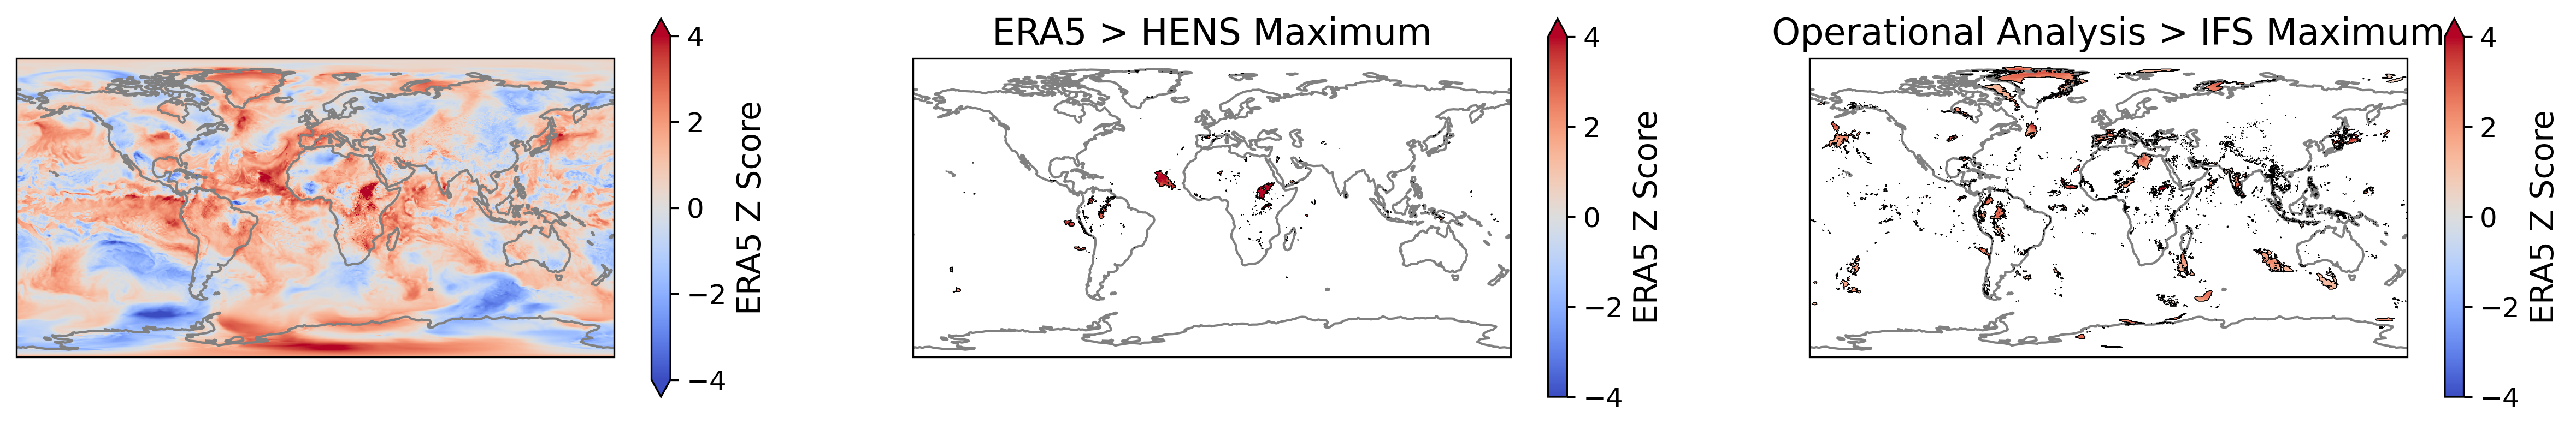

In [50]:
dates = pd.date_range('2023-06-01', '2023-08-31', freq='D')
idx = dates.get_loc('2023-08-13T00:00:00')
ds = xr.open_zarr("/pscratch/sd/a/amahesh/temp/all_era5_zscore.zarr")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw=dict(projection=ccrs.PlateCarree()), dpi=300, figsize=(20, 3))
ds.isel(initial_time=idx, time=-1)['__xarray_dataarray_variable__'].plot(ax=ax1, transform=ccrs.PlateCarree(), cmap='coolwarm', vmax=4, vmin=-4,
                                                                        cbar_kwargs={'label' : 'ERA5 Z Score'})
ax1.set_title("")
ax1.coastlines(linewidth=1, color='gray')

hensmax_misses_ds = xr.DataArray(hensmax_misses_np[idx, -1], 
                                 dims=('lat', 'lon'),
                                 coords={'lat' : ds['lat'],
                                         'lon' : ds['lon']})

(hensmax_misses_ds).plot(ax=ax2, transform=ccrs.PlateCarree(), cmap='coolwarm', vmax=4, vmin=-4,
                                                                        cbar_kwargs={'label' : 'ERA5 Z Score'})
np.isnan(hensmax_misses_ds).plot.contour(ax=ax2, linewidths=0.2, colors='black')

ax2.set_title("ERA5 > HENS Maximum")
ax2.coastlines(linewidth=1, color='gray')

ifsbust_era5_zscores_ds = xr.DataArray(ifsbust_era5_zscores_np[idx, -1], 
                                 dims=('lat', 'lon'),
                                 coords={'lat' : ds['lat'],
                                         'lon' : ds['lon']})

ifsbust_era5_zscores_ds.plot(ax=ax3, transform=ccrs.PlateCarree(), cmap='coolwarm', vmax=4, vmin=-4,
                                                                        cbar_kwargs={'label' : 'ERA5 Z Score'})
np.isnan(ifsbust_era5_zscores_ds).plot.contour(ax=ax3, linewidths=0.2, colors='black')
ax3.set_title("Operational Analysis > IFS Maximum")
ax3.coastlines(linewidth=1, color='gray')
plt.savefig("hens_max_ifs_miss_walkthrough.png")

In [4]:
hens_busts = (hensmax_misses_np > 0).astype(int)
ifs_busts = (ifsbust_era5_zscores_np > 0).astype(int)

In [5]:
weights = np.cos(np.deg2rad(dummy.lat))

In [6]:
weights = np.expand_dims(weights, axis=(0, 1, 3))
weights.shape

(1, 1, 721, 1)

In [7]:
table = np.zeros((2, 2), dtype=int)

table[1,0] = (((hens_busts > 0) & (ifs_busts == 0)) * weights).sum()
print(table)
table[1,1] = (((hens_busts > 0) & (ifs_busts > 0)) * weights).sum()
table[0,0] = (((hens_busts == 0) & (ifs_busts == 0))* weights).sum()
table[0,1] = (((hens_busts == 0) & (ifs_busts > 0))* weights).sum()


[[     0      0]
 [770528      0]]


In [8]:
table = np.zeros((2, 2), dtype=int)

table[1,0] = (((hens_busts > 0) & (ifs_busts == 0))).sum()
print(table)
table[1,1] = (((hens_busts > 0) & (ifs_busts > 0)) ).sum()
table[0,0] = (((hens_busts == 0) & (ifs_busts == 0))).sum()
table[0,1] = (((hens_busts == 0) & (ifs_busts > 0))).sum()


[[     0      0]
 [868756      0]]


In [9]:
table

array([[367970311,  12760974],
       [   868756,    472279]])

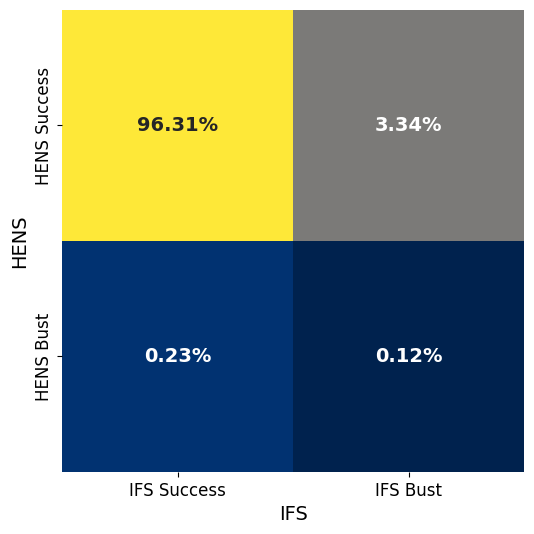

In [10]:
plt.figure(figsize=(6, 6))

def fmt(x):
    return f'{x:.2f}%'
ax = sns.heatmap(table/table.sum() * 100, annot=True, fmt='', norm='log', annot_kws={"size": 14, "weight": "bold"}, cmap="cividis", cbar=False, square=True)

# Adding percentage sign to annotations
for text in ax.texts:
    text.set_text(fmt(float(text.get_text())))

# Setting the labels for the ticks
ax.set_xticklabels(['IFS Success', 'IFS Bust'])
ax.set_yticklabels(['HENS Success', 'HENS Bust'])

# Setting axis labels
ax.set_xlabel('IFS')
ax.set_ylabel('HENS')

# plt.title('2x2 Table of HENS and IFS Busts (Percentage)')
plt.show()

In [11]:
areacella = xr.open_dataset("/pscratch/sd/a/amahesh/hens/ERA5_areacella.nc")

In [12]:
def wrap_stat(stat, name):
    dims = ('initial_condition', 'time', 'lat', 'lon')

    # Define the coordinates
    coords = {
        'initial_condition': np.arange(92),
        'time': np.arange(4),
        'lat': dummy['lat'],
        'lon': dummy['lon']
    }

    # Create the DataArray
    return xr.DataArray(stat, dims=dims, coords=coords, name=name).chunk({'initial_condition' : 1,
                                                                         'time' : 1})
ifsbust_era5_zscores_xr = wrap_stat(ifsbust_era5_zscores_np, name='ifsbust_era5_zscores')
ifsbust_hensmax_zscores_xr = wrap_stat(ifsbust_hensmax_zscores_np, name='ifsbust_hensmax_zscores')

In [13]:
import xhistogram.xarray as xhx

In [14]:
bins1 = np.linspace(0, 10, 101)
bins2 = np.linspace(0, 10, 101)

hist = xhx.histogram(ifsbust_era5_zscores_xr, ifsbust_hensmax_zscores_xr, bins=[bins1, bins2], weights=np.cos(np.deg2rad(ifsbust_era5_zscores_xr.lat)))

In [15]:
hist = hist.load()

Text(0, 0.5, 'Z Score of HENS Max')

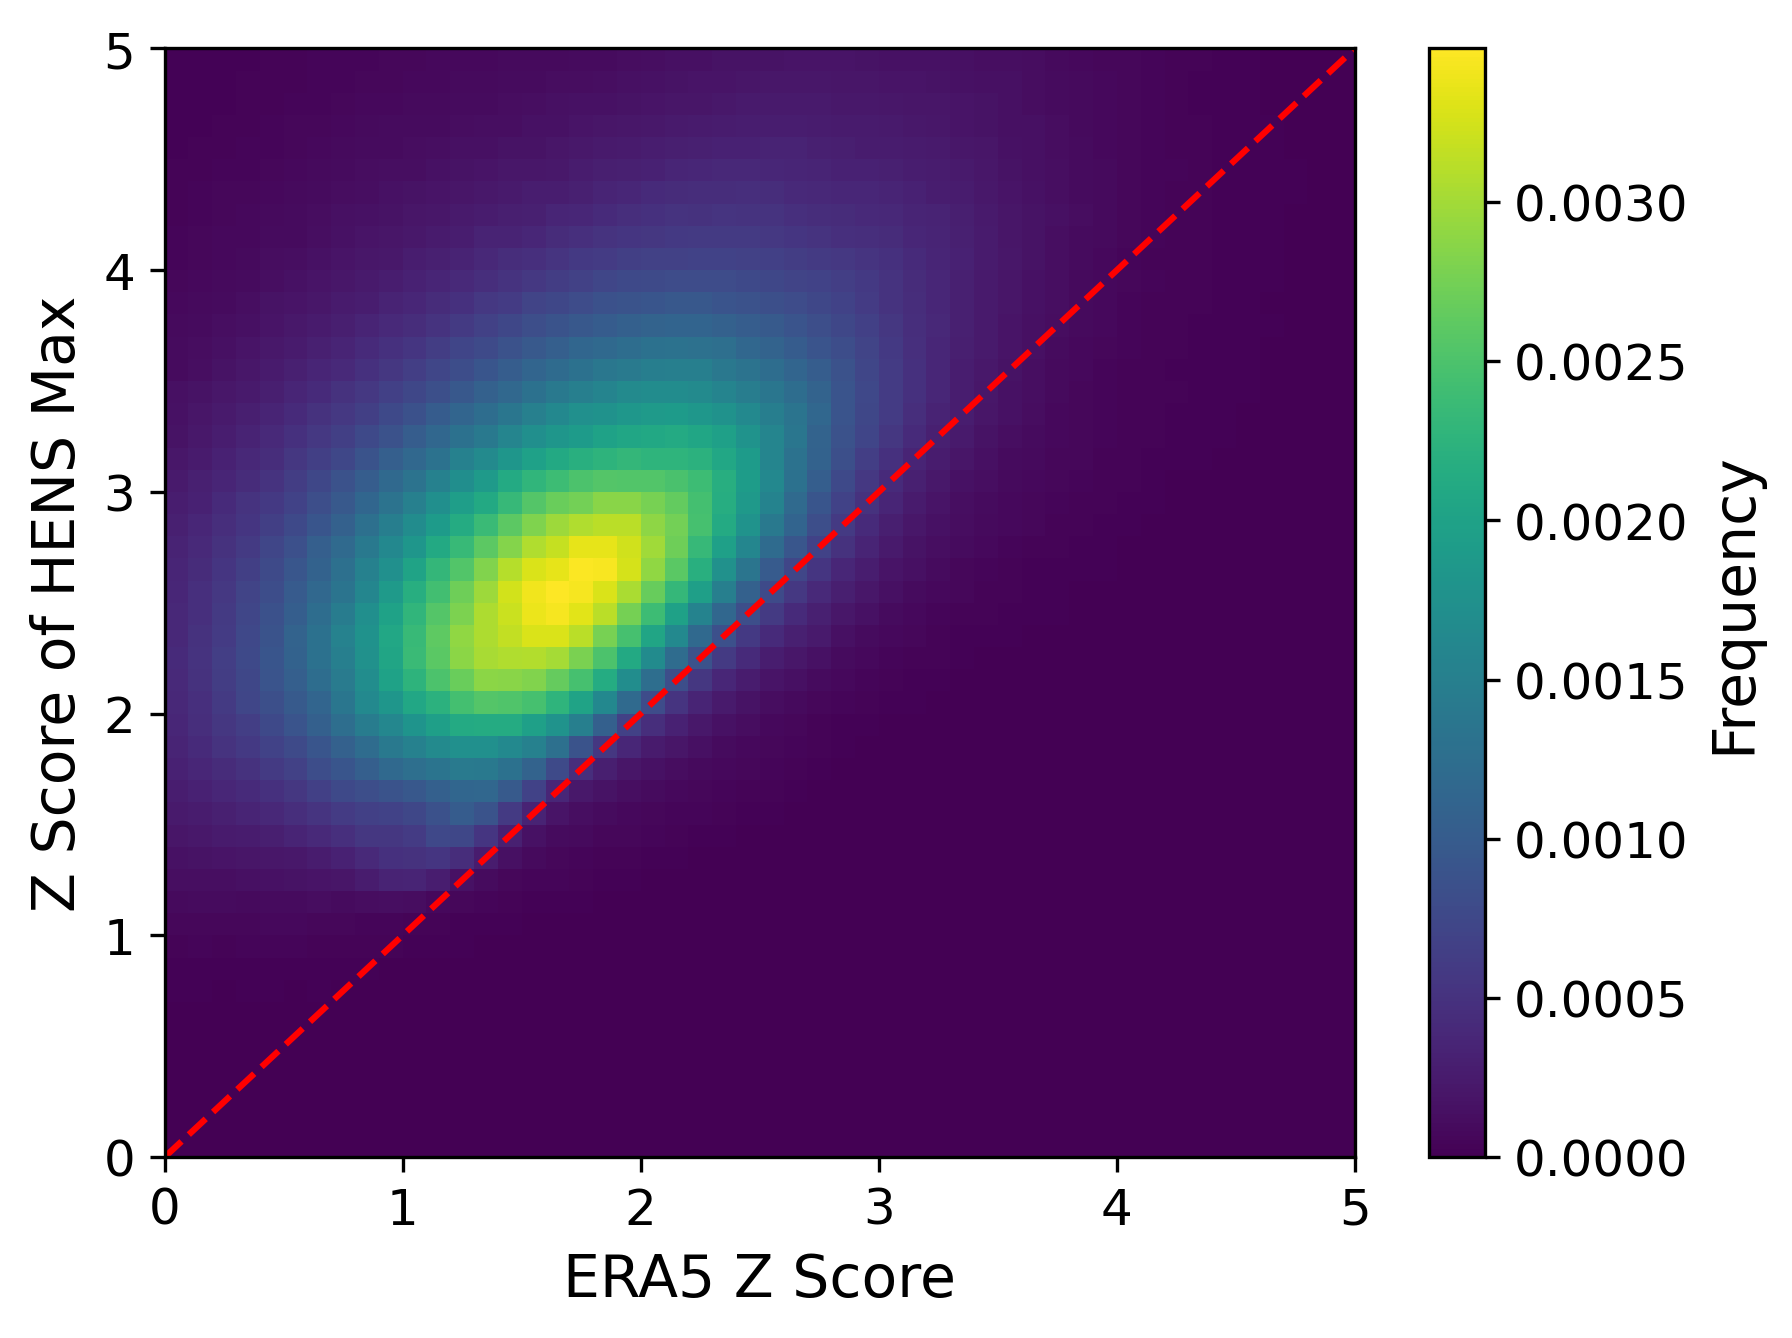

In [16]:
plt.figure(dpi=300)
(hist/hist.sum()).T.plot(
        cbar_kwargs={'label' : 'Frequency'})
plt.plot(np.arange(0,10),np.arange(0,10), linestyle='dashed', color='red')
plt.xlim((0,5))
plt.ylim((0,5))
plt.xlabel("ERA5 Z Score")
plt.ylabel("Z Score of HENS Max")

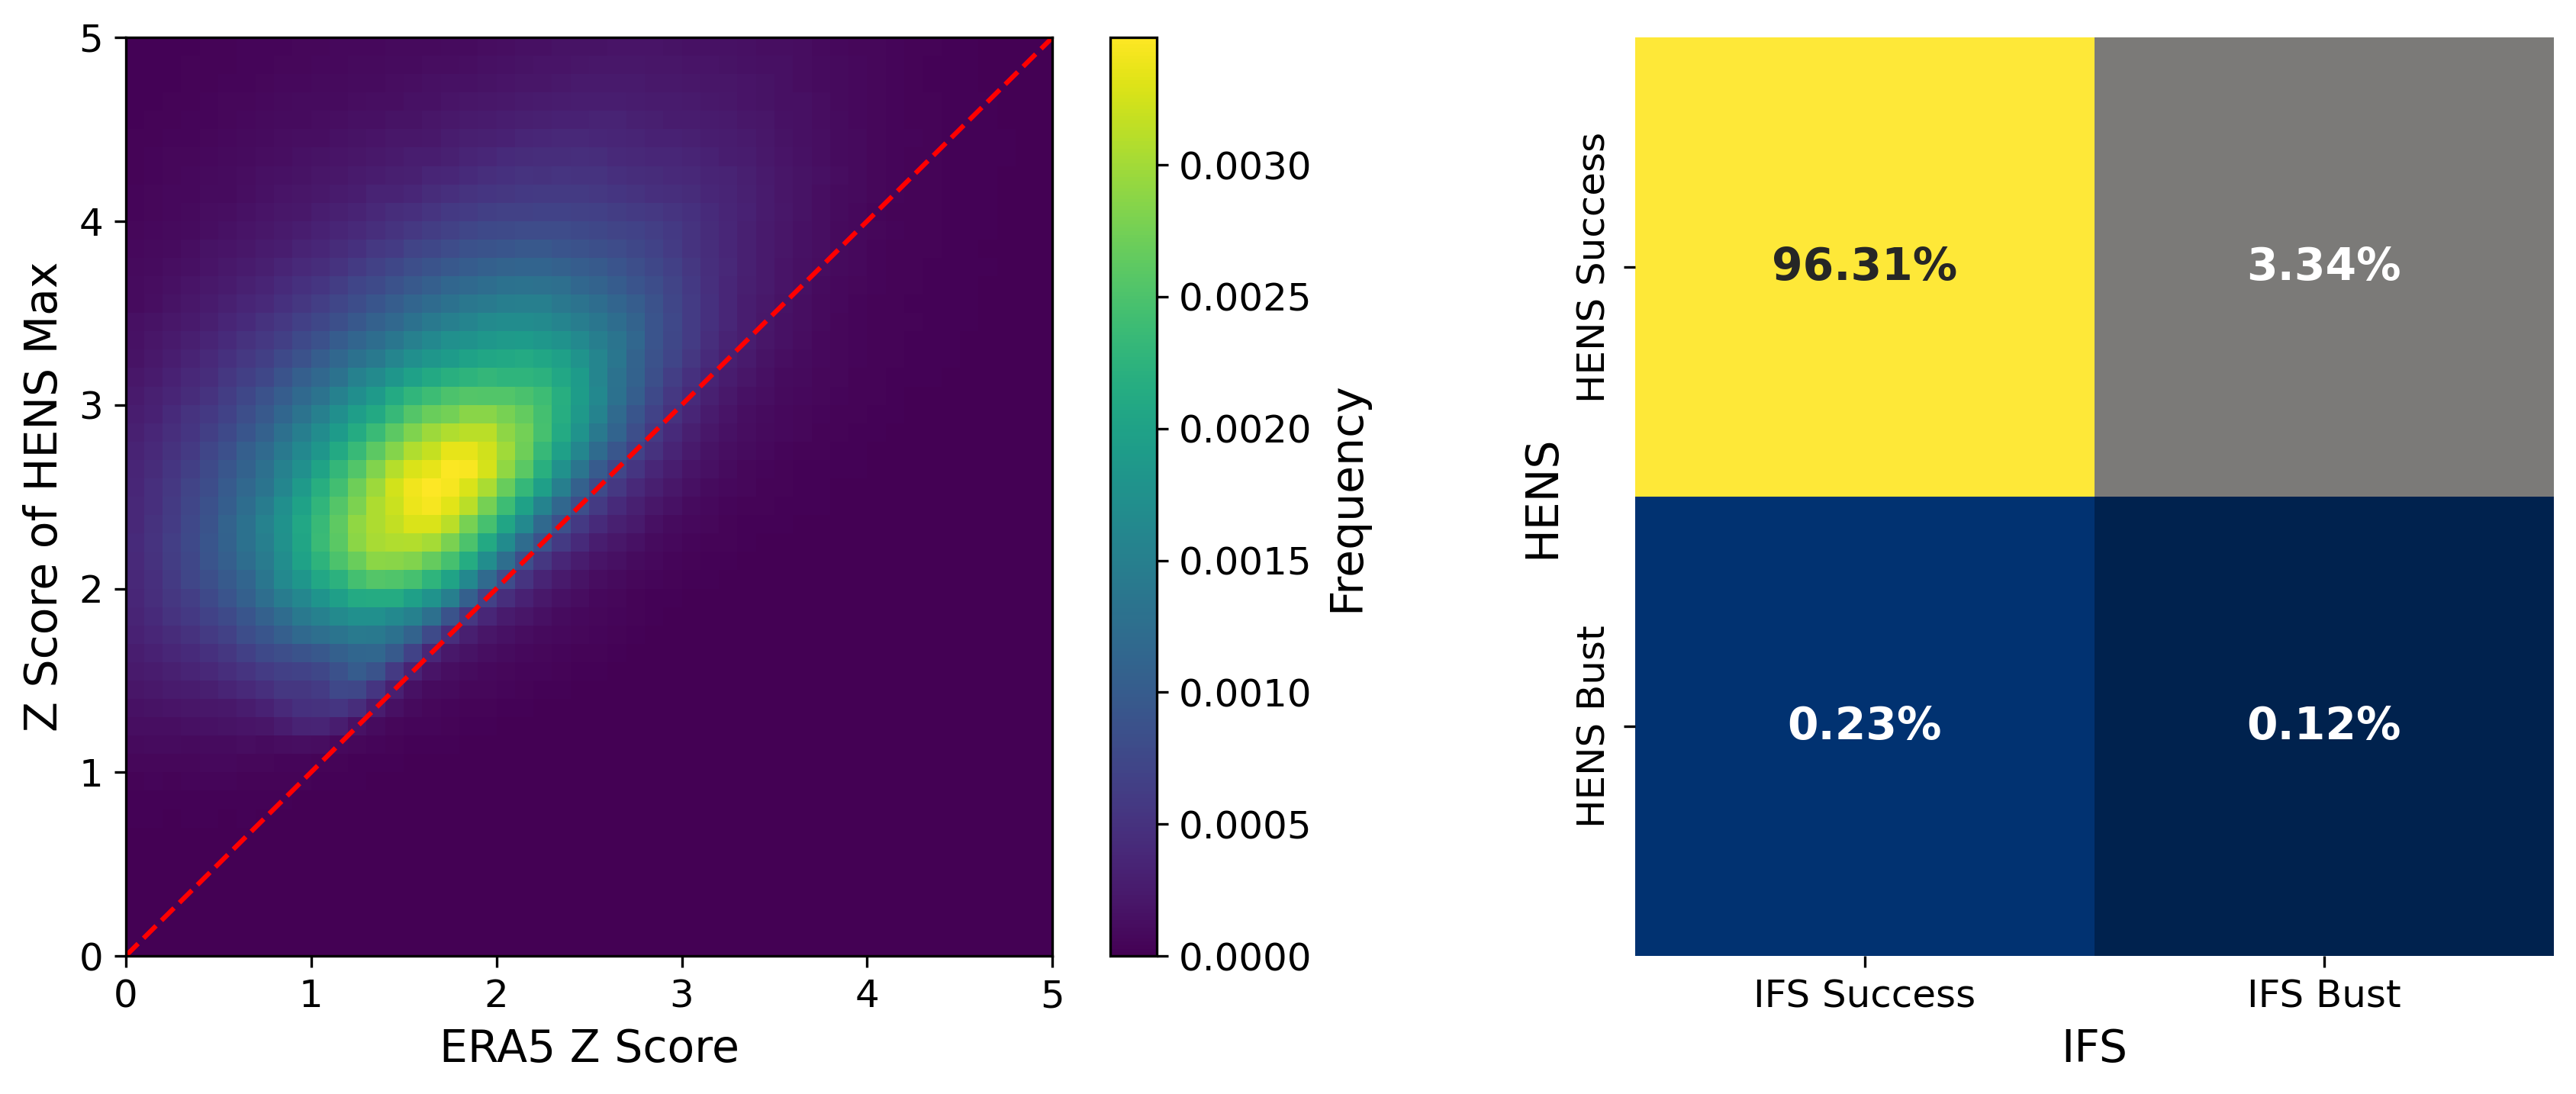

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your data here
# hist and table should be defined beforehand

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

# First plot
ax1 = axes[0]
(hist/hist.sum()).T.plot(ax=ax1, cbar_kwargs={'label': 'Frequency'})
ax1.plot(np.arange(0, 10), np.arange(0, 10), linestyle='dashed', color='red')
ax1.set_xlim((0, 5))
ax1.set_ylim((0, 5))
ax1.set_xlabel("ERA5 Z Score")
ax1.set_ylabel("Z Score of HENS Max")

# Second plot
ax2 = axes[1]
def fmt(x):
    return f'{x:.2f}%'
sns.heatmap(table/table.sum() * 100, annot=True, fmt='', norm='log', annot_kws={"size": 14, "weight": "bold"}, cmap="cividis", cbar=False, square=True, ax=ax2)

# Adding percentage sign to annotations
for text in ax2.texts:
    text.set_text(fmt(float(text.get_text())))

# Setting the labels for the ticks
ax2.set_xticklabels(['IFS Success', 'IFS Bust'])
ax2.set_yticklabels(['HENS Success', 'HENS Bust'])

# Setting axis labels
ax2.set_xlabel('IFS')
ax2.set_ylabel('HENS')

plt.tight_layout()
plt.savefig("zscore_hensmax.png")
plt.show()


In [57]:
table

array([[367970311,  12760974],
       [   868756,    472279]])

In [16]:
np.unique(ifsbust_era5_zscores[30][3] > 0)

array([False,  True])

In [7]:
hensmax = load_hensmax(dates[3], 3)

In [8]:
dates[3]

Timestamp('2023-06-04 00:00:00')

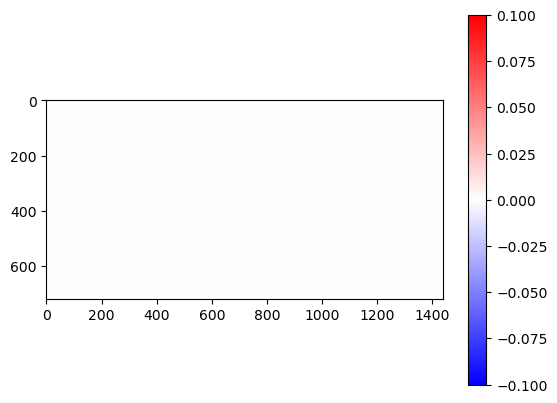

In [18]:
mpi_hensmax = xr.open_dataset('/pscratch/sd/a/amahesh/hens_h5/mpi_stats/stats_20230604.nc')
plt.imshow(mpi_hensmax['t2m_max'].values[40] - hensmax[0],cmap='bwr')
plt.colorbar()